In [38]:
TEST_PATH = '/Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf'

In [39]:
# !pip install -r ../requirements.txt

In [40]:
# uncomment these lines in case visualization does not work
# !pip install -q ipyevents
# !pip install -q ipywidgets
# !pip install -q qtpy
# !pip install -q pyvista
# !pip install pyvistaqt

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# delta, theta, alpha, beta, gamma
bands_min = [0.5, 4, 8, 12, 30]
bands_max = [4, 8, 12, 30, 45]

In [42]:
from src.graph import EEGConnectivityGraph

eeg_graph = EEGConnectivityGraph(TEST_PATH)

Extracting EDF parameters from /Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Data shape: (19, 304000)


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:13: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  self.raw = mne.io.read_raw_edf(eeg_data_path)


Extracting EDF parameters from /Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Data shape: (19, 304000)


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:11: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  self.raw = mne.io.read_raw_edf(eeg_data_path)


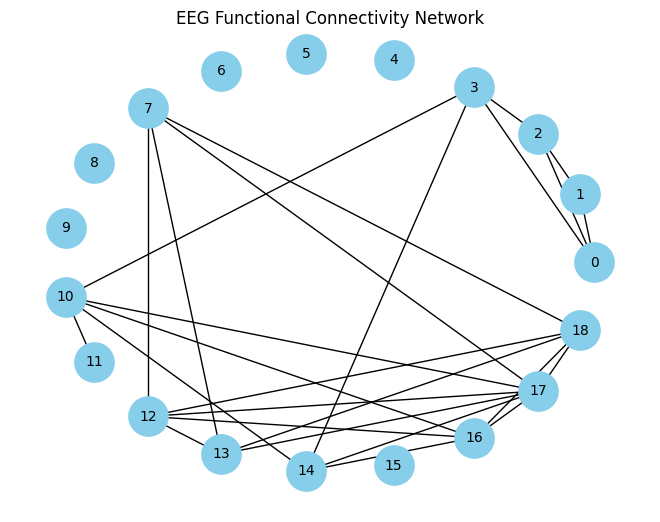

In [6]:
# Compute correlation-based connectivity and visualize as a graph
correlation_matrix = eeg_graph.compute_connectivity(method='correlation', threshold=0.6)
eeg_graph.create_graph(correlation_matrix)

### Coherence estimation

In [43]:
# Compute coherence-based connectivity and visualize as a graph
con = eeg_graph.compute_connectivity(method='coh', fmin=bands_min, fmax=bands_max)
con

Not setting metadata
1215 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1215 events and 500 original time points ...
0 bad epochs dropped
Epochs shape: (1215, 19, 500)


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:47: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


<SpectralConnectivity | freq : [3.000000, 37.000000], , nave : 1215, nodes, n_estimated : 19, 361, ~62 kB>

In [44]:
# the dimensions of the data corresponding to each axis
print(con.dims)

# the coordinates for each axis of the data
print(con.coords)

# the number of nodes matches the number of electrodes used to compute the
# spectral measure
print(con.n_nodes)

# the names of each node correspond to the electrode names
print(con.names)

('node_in -> node_out', 'freqs')
Coordinates:
  * node_in -> node_out  (node_in -> node_out) <U3 4kB '0' '1' ... '359' '360'
  * freqs                (freqs) float64 40B 3.0 6.0 10.0 21.0 37.0
19
['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']


In [45]:
# the underlying data is stored "raveled", and the connectivity measure is flattened into one dimension
print(con.shape)

# the 'dense' output will show the connectivity measure's N x N axis
print(con.get_data(output="dense").shape)

(361, 5)
(19, 19, 5)


In [28]:
from mne_connectivity.viz import plot_sensors_connectivity

epochs = eeg_graph.compute_epochs()
con_data = con.get_data(output="dense")[:, :, 0]
con_data.shape

(19, 19)

In [93]:
%%writefile src/plot.py

# plot the connectivity matrix for all bands
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

bands = {0: 'delta', 1: 'theta', 2: 'alpha', 3: 'beta', 4: 'gamma'}


def plot_connectivity_maps(con_data, n_connections=20):
    # con_data: (n_channels, n_channels, n_freqs)
    fig, axs = plt.subplots(1, con_data.shape[-1], figsize=(20, 5))
    for band in range(con_data.shape[-1]):
        cur = con_data[:, :, band]

        threshold = np.sort(cur, axis=None)[-n_connections]
        cur = cur > threshold

        axs[band].set_title(f'Band {bands[band]}')
        axs[band].imshow(cur, cmap='viridis')

def plot_graphs(con_data, n_connections=20, channel_names=None):
    fig, axs = plt.subplots(1, con_data.shape[-1], figsize=(20, 5))
    for band in range(con_data.shape[-1]):
        cur = con_data[:, :, band]

        threshold = np.sort(cur, axis=None)[-n_connections]
        cur = cur > threshold

        G = nx.from_numpy_array(cur)
        pos = nx.circular_layout(G)  # Layout nodes in a circle
        axs[band].set_title(f'Band {bands[band]}')
        nx.draw(G, pos, ax=axs[band], with_labels=True, labels=channel_names, node_color='skyblue', node_size=800, font_size=10)

Overwriting src/plot.py


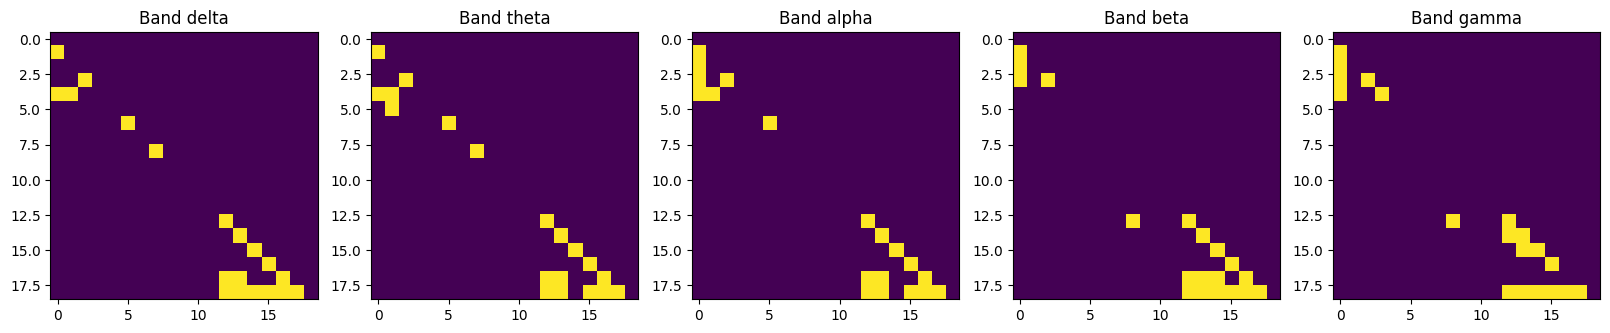

In [94]:
from src.plot import plot_connectivity_maps, plot_graphs

con_data = con.get_data(output="dense")
plot_connectivity_maps(con_data)

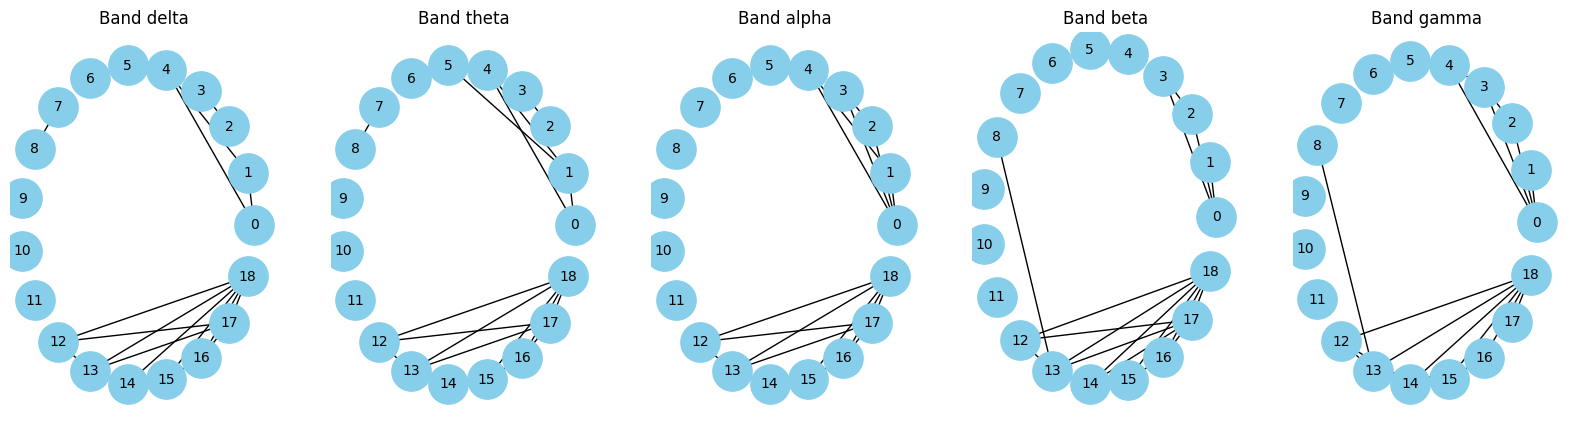

In [95]:
plot_graphs(con_data)

In [30]:
info = epochs.info
info["chs"][0]

{'cal': 1.0,
 'logno': 1,
 'scanno': 1,
 'range': 1.0,
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'FP1',
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'coil_type': 1 (FIFFV_COIL_EEG),
 'kind': 2 (FIFFV_EEG_CH),
 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

In [99]:
channel_names = {i: ch["ch_name"] for i, ch in enumerate(info["chs"])}
channel_names

{0: 'FP1',
 1: 'FP2',
 2: 'F7',
 3: 'F3',
 4: 'Fz',
 5: 'F4',
 6: 'F8',
 7: 'T3',
 8: 'C3',
 9: 'Cz',
 10: 'C4',
 11: 'T4',
 12: 'T5',
 13: 'P3',
 14: 'Pz',
 15: 'P4',
 16: 'T6',
 17: 'O1',
 18: 'O2'}

In [22]:
# no 3d plot because no information about the sensor locations
# plot_sensors_connectivity(epochs.info, con_data, con.names, cbar_label='Coherence', n_con=20)

### PLV estimation

In [86]:
eeg_graph = EEGConnectivityGraph(TEST_PATH)

con_plv = eeg_graph.compute_connectivity(method='plv', fmin=bands_min, fmax=bands_max)
con_plv

Extracting EDF parameters from /Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Data shape: (19, 304000)
Not setting metadata
1215 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1215 events and 500 original time points ...


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:13: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  self.raw = mne.io.read_raw_edf(eeg_data_path)


0 bad epochs dropped
Epochs shape: (1215, 19, 500)


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:47: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


<SpectralConnectivity | freq : [3.000000, 37.000000], , nave : 1215, nodes, n_estimated : 19, 361, ~62 kB>

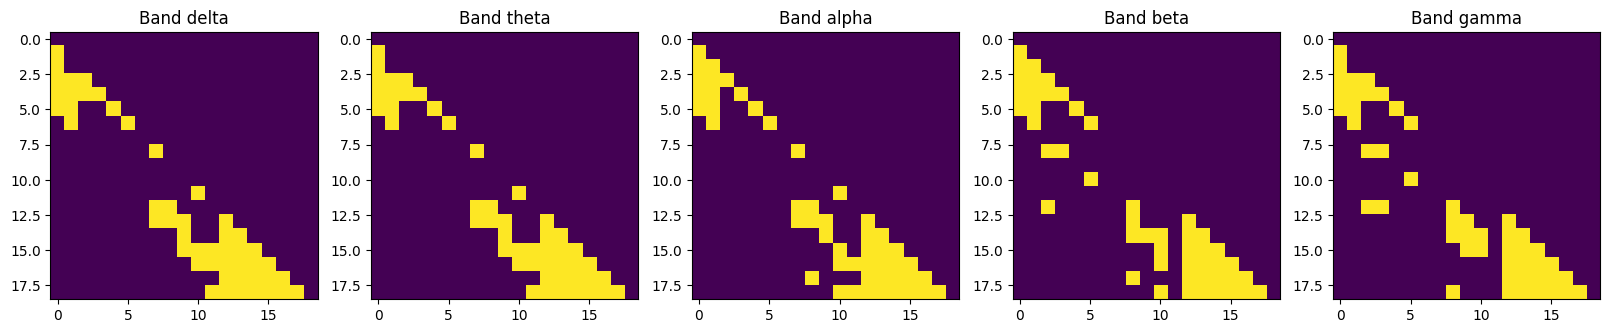

In [87]:
plot_connectivity_maps(con_plv.get_data(output="dense"), n_connections=50)

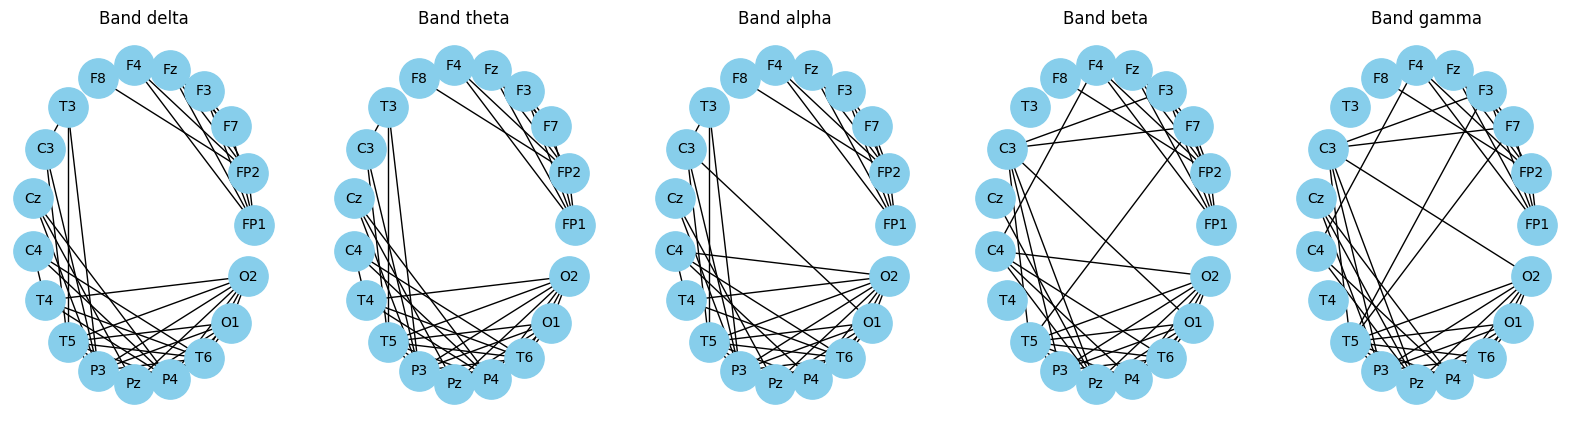

In [100]:
plot_graphs(con_plv.get_data(output="dense"), n_connections=50, channel_names=channel_names)

### PLI estimation

In [101]:
eeg_graph = EEGConnectivityGraph(TEST_PATH)

con_pli = eeg_graph.compute_connectivity(method='pli', fmin=bands_min, fmax=bands_max)
con_pli

Extracting EDF parameters from /Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Data shape: (19, 304000)
Not setting metadata
1215 matching events found
No baseline correction applied
0 projection items activated


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:13: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  self.raw = mne.io.read_raw_edf(eeg_data_path)


Loading data for 1215 events and 500 original time points ...
0 bad epochs dropped
Epochs shape: (1215, 19, 500)


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:47: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


<SpectralConnectivity | freq : [3.000000, 37.000000], , nave : 1215, nodes, n_estimated : 19, 361, ~62 kB>

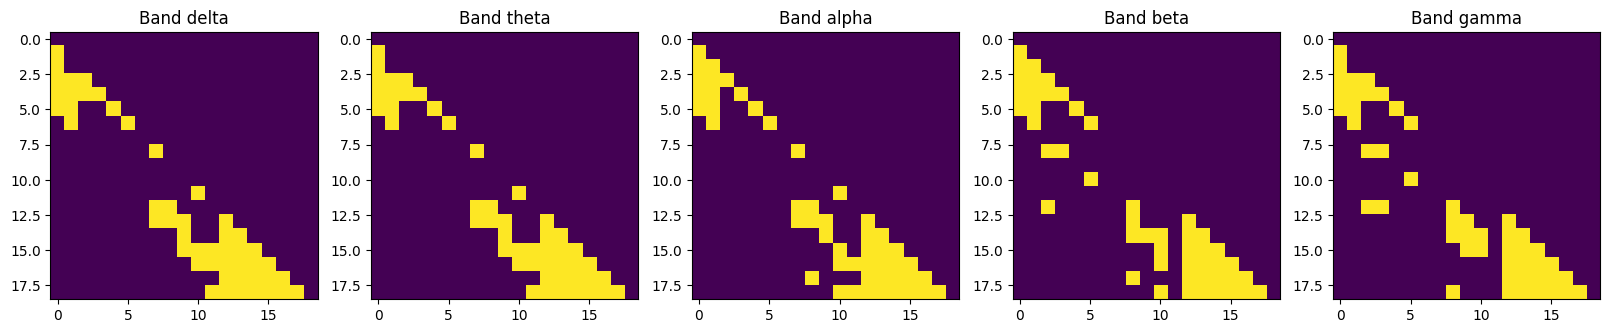

In [102]:
plot_connectivity_maps(con_pli.get_data(output="dense"), n_connections=50)

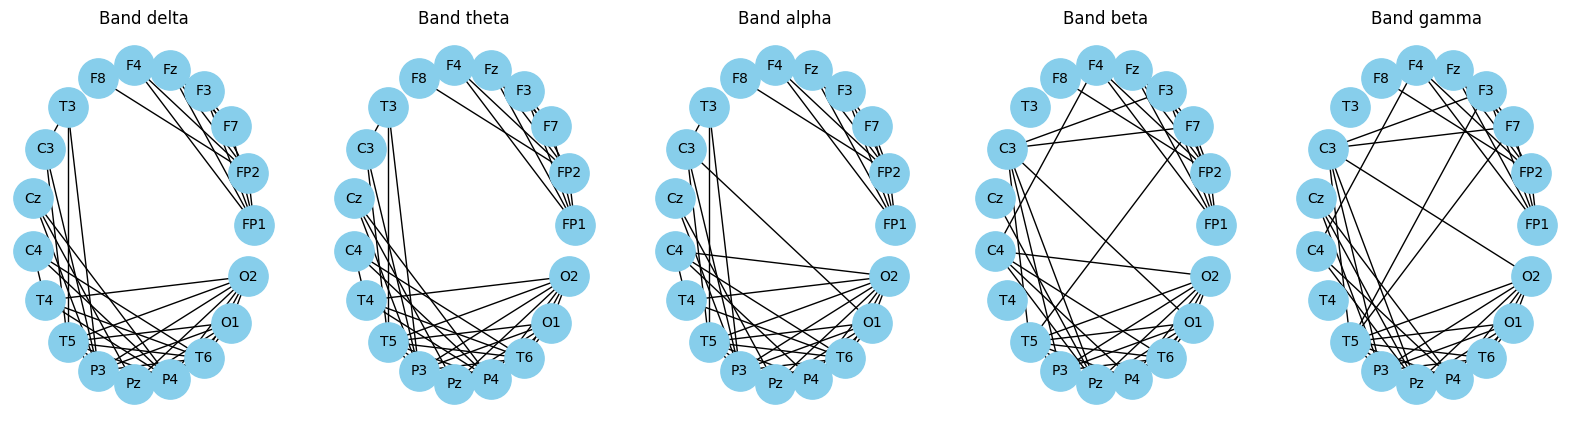

In [103]:
plot_graphs(con_pli.get_data(output="dense"), n_connections=50, channel_names=channel_names)

In [105]:
np.isclose(con_pli.get_data(output="dense"), con_plv.get_data(output="dense")).all() # wtf

True

In [125]:
%%writefile src/parse_deap.py

# iterate over data folder:
import os
import argparse
import numpy as np
from tqdm import tqdm

from graph import EEGConnectivityGraph

bands_min = [0.5, 4, 8, 12, 30]
bands_max = [4, 8, 12, 30, 45]

# parse args
parser = argparse.ArgumentParser(description='Compute connectivity measures for DEAP dataset')
parser.add_argument('--method', type=str, default='coh', help='Connectivity method')
args = parser.parse_args()

data_path = '/Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered'
sub_folders = sorted([folder for folder in os.listdir(data_path) if folder.startswith('sub')])

for sub_folder in tqdm(sub_folders):
    print(f'Processing {sub_folder}')
    sub_path = os.path.join(data_path, sub_folder)
    sub_path = os.path.join(sub_path, 'eeg')
    eeg_files = [file for file in os.listdir(sub_path) if file.endswith('.edf')]
    for eeg_file in eeg_files:
        eeg_path = os.path.join(sub_path, eeg_file)
        eeg_graph = EEGConnectivityGraph(eeg_path)
        con = eeg_graph.compute_connectivity(method=args.method, fmin=bands_min, fmax=bands_max)
        con_data = con.get_data(output="dense")

        # save the connectivity data
        con_path = eeg_path.replace('.edf', '_{}.npy'.format(args.method))
        np.save(con_path, con_data)


Overwriting src/parse_deap.py


In [127]:
# !python3 src/parse_deap.py --method plv